# Guided Mutations

So far, we have essentially created inputs _randomly_, in the hope that these may eventually trigger a bug.  If we can feed in knowledge about the program behavior, we can be much more efficient in creating useful inputs.  The key to success lies in the idea of _guiding_ these mutations – that is, _keeping those that are especially valuable._  "Valuable" might mean that they would be syntactically valid, but also that they help covering more implemented behavior.

**Prerequisites**

* This chapter extends our previous implementation of mutation-based fuzzing from the ["Mutation-Based Fuzzing"](Mutation_Fuzzing.ipynb) chapter.
* You should understand how to measure code coverage; for instance from the ["Coverage"](Coverage.ipynb) chapter.

## Multiple Mutations

So far, we have only applied one single mutation on a sample string.  However, we can also apply _multiple_ mutations, further changing it.  What happens, for instance, if we apply, say, 20 mutations on our sample string?

In [1]:
import fuzzingbook_utils

In [2]:
%%capture
from Mutation_Fuzzing import mutate, is_valid_expr, valid_inputs

In [3]:
seed_input = "1 + 2 * 3 / 4"
MUTATIONS = 20
inp = seed_input

In [4]:
for i in range(MUTATIONS):
    inp = mutate(inp)
    print(repr(inp))

'1 + 2 * 3 / '
'1 + 2 * 3  '
'1 + 2 * 3 '
'1 + 2 *03 '
'1 + 2 *0 '
'1 + 2 *0`'
'0 + 2 *0`'
'0 + 2/ *0`'
'0 + 2/ >*0`'
'0 + 2/ >*0d'
'50 + 2/ >*0d'
'50 + 2- >*0d'
'50 + 2- >*d'
'50 + 2- >*'
'50 + - >*'
'50 +  >*'
'50 +/  >*'
'58 +/  >*'
'58 :+/  >*'
'"58 :+/  >*'


As you see, the original seed input is hardly recognizable anymore.  Mutating the input again and again has the advantage of getting a higher variety in the input, but on the other hand further increases the risk of having an invalid input.

The key to success lies in the idea of _guiding_ these mutations – that is, _keeping those that are especially valuable._  For instance, we may want to keep those samples that happen to be _valid_, and keep on mutating these.  To this end, we proceed as follows:

1. We keep a population of seen valid inputs `population`, initialized with the seed input.
2. We pick a random (valid) candidate from this set, which we now mutate up to `MAX_MUTATIONS` times.
3. If the candidate is valid and new, we add it to `population`.
4. In the next iterations, the previous candidates can be chosen again as seeds.

Here's the full code:

In [5]:
import random

In [6]:
def create_candidate(population):
    MIN_MUTATIONS = 2
    MAX_MUTATIONS = 10

    candidate = random.choice(population)
    trials = random.randint(MIN_MUTATIONS, MAX_MUTATIONS)
    for i in range(trials):
        candidate = mutate(candidate)
    return candidate

In [7]:
def create_population(seed, size):
    population = seed
    while len(population) < size:
        candidate = create_candidate(population)
        if is_valid_expr(candidate) and candidate not in valid_inputs:
            population.append(candidate)
    return population

In [8]:
seed_input = "1 + 2 * 3 / 4"
POPULATION_SIZE = 20
create_population(seed=[seed_input], size=POPULATION_SIZE)

['1 + 2 * 3 / 4',
 '19+ 2 * 3 / 4',
 '1 <k2 & 2 / 4',
 '1 <k2+  2 / 4',
 '1 <+2 & 2 / 0',
 '1 \n<2+0 /9',
 '1 <  2 / 4',
 '1 <k+  2 //7',
 '3 <k+ 2 /7',
 '1 /2 & 2 / 0',
 '1<+ 41& 0/ 2',
 '1 /2 & 2 / 0',
 '1 <k  =2//7',
 '\n2+9',
 '3<k+2 /7',
 '0 <k  =3//7',
 '\n2+69',
 ' +4 ',
 '',
 '']

As you can see, we now get an even larger variety of inputs.  If you are using the interactive notebook version of this chapter, you can toy with different settings (such as `MAX_MUTATION`) to see how they influence the outputs.  (Also see the [Exercises](#Exercises) below.)

## Maximizing Diversity

A good set of tests not only consists of valid inputs, but the inputs should also be _as diverse as possible_: If you already have tested `1 + 1`, then testing for `1 + 2` or `1 + 1 + 1` is not going to cover much additional functionality, compared to, say, `15.0 / 7`.  To easily ensure a greater diversity, we can check for two features: _length_ and _input elements_.


### Diversity through Length

A simple way to increase diversity in our setting is ro favor _longer inputs_.  The argument is simple: The longer a randomly generated input is, the higher its chances to cover several program features.  Let us define a function `evolve_population()` that 

1. Sorts the population in ascending order according to its _fitness_ (the length)
2. Replaces the first element in the population by a new, fitter (longer) one

This is what this looks like:

In [9]:
def evolve_population(population, fitness=len, steps=100):
    evolutions = 0
    while evolutions < steps:
        population.sort(key=fitness)

        candidate = create_candidate(population)
        if is_valid_expr(candidate) and fitness(candidate) > fitness(population[0]):
            population[0] = candidate
            evolutions += 1

    return population

Let us try out `evolve_population()` with a sample population in which one element `25` is the shortest and thus would be replaced by a new, longer element:

In [10]:
evolve_population(population=['1 + 1', '1 + 1 + 1', '25'], steps=1)

['  1', '1 + 1', '1 + 1 + 1']

We can now use this to evolve a population over several iterations.  We can see that the strings get longer and longer:

In [11]:
population = create_population(seed=[seed_input], size=POPULATION_SIZE)
evolve_population(population)

['" -*9-6.5925=\'!")=5(7',
 '+ -2*"<+4)?(693" /4',
 '0+ m2*"*+)?6983" /4',
 '+ -72*"<+$i?,693" /4',
 't21%"-6.525=\'!")/5(7',
 '0+ -2*"*+)?6$93" /45',
 '421%"-6,52597")/5(7 ',
 '41%"-652*797")/+5(7 ',
 '0+ m2*"*+)?693<3" /4',
 '48%"v52*)797")//+5(7 ',
 '48%"-v52*797")//+5(7 ',
 '42%".)/6,529\'n ")/(7 ',
 '4>23%"- 6\x0c7597")/5(7 ',
 '421%"-6,5259\' ")/5(7 ',
 '42&1%"-6,5259\'. ")/5(7',
 '+ -72*"<+$i?,69/$3" /4',
 '421%"-6,5259\'. ")/5(7 ',
 '4>23%"- 6\x0c7597")//5(78 ',
 '42%".)/6,52%9\'n ")/5(7 ',
 '42%".)/6,52%9\'n ")/5(7 ']

### Diversity in Input Elements

Not only do we want long inputs, but we also want diversity in input elements.  For instance, we'd like our inputs to cover as many arithmetic operations as possible: The input `1 + 2 * 3` is shorter than the input `1234567890`, yet covers more operations.  We can achieve this by defining a special fitness function that favors inputs with a large diversity in input characters.

In [12]:
def diversity_fitness(s):
    return len(set(s))

Here, `len(set(s))` returns the size of the set of characters in `s` – that is, the number of different characters:

In [13]:
diversity_fitness("1 + 1")

3

We can see that this gives us even more diverse inputs:

In [14]:
evolve_population(population, fitness=diversity_fitness)

['4205+"-0*7)-\x0f5,\x1418u9\'1d.$")#/=(?)',
 'k-79*-"9+$7 ?,#6)\x0f1.&#,86;32"/4',
 '42550+"*7)\x0f,172xe%9\'14l.$")#/%?)2%p:',
 '405+"-0*7)-\x0f5,\x1418u9\'1.$")#//=(?(p',
 '4255+"*7)\x1f,xe%9#1l. ")#!"/%?)2%p:$:',
 '4255+"j7)\x0f,\x14,1:2xe%9\'1l.$" )#"%?)2%p:',
 '4255+"*7)\x1f,\x142xe%9#1l.$")#!"/%?)2%p:$:',
 '4255+"*7)\x0f,\x1412xe%9\'1l.$")#"/%?)2%p:',
 'k-7*-"9+$7i ?8,#67)\x0f1.&#,86;32"/4',
 'k-79-"+$>7\x10,#&v.)\x0f1&.>,86;\'!2"/4',
 '405+"-0*7)\x0f,\x14128u9\'1l.$")#/-?)2p',
 '555+"*\'7q\x0f\x16(\x141)8a9\'9l\x0e$")#"/2%?)2p',
 '4255+"*7)\x0f6,\x14128e9\'1l.$")#"/%?)2p',
 'k-7*-"9+$7i ?,#6)\x0f1.&#,86;32"/4',
 '405+"-0*7)-\x0f5,\x1418u9\'1d.$")#/=(?)p',
 '4255+"*7)\x0f6,\x14128e%9\'1l.$")#"/%?)2p:',
 '455+"*\'71)\x0f6,\x1418a9\'9l.$")#"/:%?)2p',
 '455+"*\'71)\x0f6&,\x1418a9\'9l.$")#"/:%?.)$2p',
 ' 372*"#++5\x0b$y?*)l>#04\x19\'?%t<!1=," /5',
 ' 637*2*"#++5\x0b$y?*)l>#04\x19\'?%t\'<!1=,>" /5']

However, there's a catch: As soon as our input contains a comment (a substring starting with `#`), any characters are allowed after the `#`.  The same holds if our input contains a quoted string (`'...'` or `"..."`); then arbitrary characters can be added to the string.  We may thus achieve diversity in comments or strings, but we will miss _diversity in functionality_.

This, of course, is one of the central problems of software testing: How can I cover all functionality of the program under test – including all its bugs?  Fortunately, researchers and practitioners have devised a great number of solutions to address this problem.

## Guiding by Coverage

To cover as much functionality as possible, one can rely on either _specified_ or _implemented_ functionality, as discussed in the ["Coverage"](Coverage.ipynb) chapter.  For now, we will not assume that there is a specification of program behavior (although it _definitely_ would be good to have one!).  We _will_ assume, though, that the program to be tested exists – and that we can leverage its structure to guide test generation.

Since testing always executes the program at hand, one can always gather information about its execution – the least is the information needed to decide whether a test passes or fails.  Since coverage is frequently measured as well to determine test quality, let us also assume we can retrieve coverage of a test run.  The question is then: _How can we leverage coverage to guide test generation?_

One particularly successful idea is implemented in the popular fuzzer named [_American fuzzy lop_](http://lcamtuf.coredump.cx/afl/), or AFL for short.  Just like our examples above, AFL evolves test cases that have been successful – but for AFL, "success" means _finding a new path through the program execution_.  This way, AFL can keep on mutating inputs that so far have found new paths; and if an input finds another path, it will be retained as well.

We can implement such a strategy by maximizing _diversity in coverage_ in our population.



In [15]:
%%capture
from Coverage import Coverage, cgi_decode, population_coverage_cgi_decode

In [30]:
def evolve_population_by_coverage(seed, trials=100):
    population = []
    population_coverage = set()
    
    def evaluate_candidate(candidate):
        nonlocal population
        nonlocal population_coverage
       
        with Coverage() as cov:
            try:
                cgi_decode(candidate)
            except:
                pass
            
        # print(repr(candidate))

        new_coverage = frozenset(cov.coverage())
        if new_coverage not in population_coverage:
            # We have new coverage
            population.append(candidate)
            population_coverage.add(new_coverage)

    for candidate in seed:
        evaluate_candidate(candidate)
   
    for i in range(trials):
        candidate = create_candidate(population)
        evaluate_candidate(candidate)

    return population

In [31]:
population = evolve_population_by_coverage(seed=["Hello+world"], trials=1000)
population

['Hello+world',
 'Hello)wnrl',
 'H%9lo,#3+wrde',
 'nlo+ul%',
 '%9d\x7f,3+wrdd.',
 '%=00d\x7f,3#.-+wr ld&.',
 '#%9d\x7f,,;wrdd.',
 'nl$o8*Ul%',
 '%00d\x7f,3#3*.-$)w %md&0*',
 "%00d\x7f,3+;*'.-$)w %m&d&0*",
 "!00d\x7f,3+;*'.-$)'W %m&d&0*",
 '%5006! !d\x7f,3.-+wr7ld&.%',
 '%5006! !d\x7f3.-\x0bwr7ld&.%']

Success!  In our population, _each and every input_ now has a different coverage, coming from various combinations of `'+'`, `'%'` (valid and invalid ones), and regular characters.  Altogether, they cover the entire program.

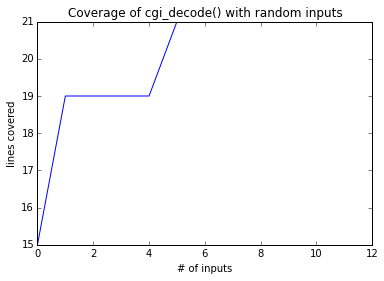

In [29]:
cumulative_coverage = population_coverage_cgi_decode(population)

import matplotlib.pyplot as plt
plt.plot(cumulative_coverage)
plt.title('Coverage of cgi_decode() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

The nice thing about this strategy is that, applied to larger programs, it will happily explore one path after the other – covering functionality after functionality.  All that is needed is a means to capture the coverage.

## Lessons Learned

* Coverage can help a lot in guiding mutations.

## Next Steps

In the next chapter, we shall try to cover as much _specified_ functionality as possible.  Here, we would need a specification of the input format, distinguishing between individual input elements – and attempting to cover as many of these as possible.  We will explore this as it comes to [grammar-based testing](Grammar_Testing.ipynb).

One alternative to pure random testing is [symbolic testing](Symbolic_Testing.ipynb), also known as _constraint-based testing_.  Symbolic testing analyzes the _static_ code structure and attempts to resolve the conditions that lead to yet uncovered paths – and thus, yet uncovered behavior.

Finally, the concept of a "population" that is systematically "evolved" through "mutations" will be explored in depth when discussing [search-based testing](Search_Based_Testing.ipynb).  Enjoy!


## Exercises


### Exercise 1

Rather than adding elements to the population when a new coverage is discovered, one may also add elenents if they discover a new line.  Does this make a difference?

### Exercise 2

To achieve diversity in our set of inputs, one may also try to maximize the _difference_ between the individual inputs in the population.  Rather than sorting the population and replace the least fit individual, we could also compare all individuals against each other and pick the one that is most similar to all the others.  For instance, one could define similarity as the ratio of which characters are common in both strings:

In [21]:
def similar(s1, s2):
    return len(set(s1) & set(s2)) / len(set(s1) | set(s2))

In [22]:
assert similar("A", "A") == 1.0
assert similar("A", "B") == 0

Here, `a & b` and `a | b` denote the intersection and union of two sets, respectively.

The more the set of characters in two strings is the same, the higer the value of `similar()`:

In [23]:
similar("Apple", "Microsoft")

0.0

In [24]:
similar("Python", "Boa constrictor")

0.23076923076923078

In [25]:
similar("Python 2", "Python 3")

0.7777777777777778

When it comes to remove one element from the population, use the above `similar()` implementation to determine the one element that is most similar to all the others.  Report a typical output sample.   How expensive is your approach?

### Exercise 3

Python brings an [impressive library for computing the difference between strings](https://docs.python.org/3/library/difflib.html), which we can use to measure similarity between two strings including the ordering of characters:

In [26]:
from difflib import SequenceMatcher

In [27]:
def similar(s1, s2):
    return SequenceMatcher(None, s1, s2).ratio()

Repeat [Exercise 2](#Exercise-2) with the above.